## Assignment 3 Breast Cancer Stage Classification

Breast cancer (BRCA) is the most common cancer in women. One important task to improve the survival rate of BRCA patients is identifying the cancer stage and applying different treatment strategies. We can train a model to classify cancer stages using RNA-seq of patient samples. 

Tasks:
1.	Prepare a dataset using TCGA-BRCA RNA-Seq data as features and cancer stages as labels. (Hint: you can find the processed RNA-Seq data and patient phenotype data from UCSC Xena)
2.	Applying data processing methods. (Normalization, Training-Test split, etc.)
3.	Applying three different classification estimators and optimizing the parameters through cross-validation.
4.	Comparing three estimators by evaluating the performance on the test dataset.
5.	Applying feature selection to improve performance.


### Task 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

In [2]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import numpy as np
import pandas as pd

In [3]:
reads = pd.read_csv('TCGA-BRCA.htseq_fpkm.tsv', sep='\t', header=0)
label = pd.read_csv('TCGA-BRCA.GDC_phenotype.tsv', sep='\t', header=0)

In [7]:
reads

,Ensembl_ID,TCGA-E9-A1NI-01A,TCGA-A1-A0SP-01A,TCGA-BH-A1EU-11A,TCGA-A8-A06X-01A,TCGA-E2-A14T-01A,TCGA-AC-A8OS-01A,TCGA-A8-A09K-01A,TCGA-OL-A5RY-01A,TCGA-BH-A0DG-01A,...,TCGA-BH-A0DT-11A,TCGA-E9-A1R0-01A,TCGA-BH-A0B6-01A,TCGA-B6-A0RN-01A,TCGA-A8-A09W-01A,TCGA-EW-A1P3-01A,TCGA-A7-A13F-11A,TCGA-A2-A0T6-01A,TCGA-A7-A5ZW-01A,TCGA-BH-A203-01A
0,ENSG00000242268.2,0.091708,0.000000,0.057899,0.000000,0.000000,0.354334,0.000000,0.000000,0.000000,...,0.234169,0.107850,0.000000,0.000000,0.000000,0.000000,0.471630,0.083825,0.000000,0.061585
1,ENSG00000270112.3,0.019573,0.004701,0.016302,0.000000,0.000000,0.000000,0.005787,0.000000,0.000000,...,0.000000,0.003879,0.010047,0.000000,0.010919,0.000000,0.000000,0.000000,0.005858,0.008704
2,ENSG00000167578.15,2.235898,1.863334,1.704753,1.947481,2.734690,2.397119,2.337327,2.256976,1.968791,...,1.928209,2.004722,2.971522,1.841232,1.185122,2.861514,1.626213,1.692995,2.051916,2.197365
3,ENSG00000273842.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ENSG00000078237.5,2.321945,4.226699,1.975755,2.808757,1.964479,1.792870,1.939951,2.681632,2.091932,...,2.024599,2.216023,2.124097,1.665709,2.217943,2.120565,1.605675,2.055448,2.195782,3.291072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60478,ENSG00000105063.17,3.680055,3.969785,3.011921,4.059347,4.249147,3.935869,4.082827,3.931459,3.870035,...,3.348868,3.650676,4.478325,3.520017,3.372176,3.772585,3.133380,4.186347,3.340223,3.966532
60479,ENSG00000231119.2,0.285640,0.115149,0.384451,0.345883,0.065679,0.837305,0.198863,0.216728,0.102007,...,0.329875,0.232873,0.069587,0.117933,0.343273,0.149851,0.270187,0.484561,0.127070,0.174248
60480,ENSG00000280861.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60481,ENSG00000123685.7,0.599579,1.382192,0.629043,0.396315,0.157504,0.662529,0.174878,1.724989,0.580636,...,0.487383,0.491877,1.261285,0.407713,0.379536,0.551165,0.611319,0.706170,0.683710,0.430933


In [8]:
label.loc[label['tumor_stage.diagnoses'] == 'stage ia', 'tumor_stage.diagnoses'] = 'stage i'
label.loc[label['tumor_stage.diagnoses'] == 'stage ib', 'tumor_stage.diagnoses'] = 'stage i'
label.loc[label['tumor_stage.diagnoses'] == 'stage iia', 'tumor_stage.diagnoses'] = 'stage ii'
label.loc[label['tumor_stage.diagnoses'] == 'stage iib', 'tumor_stage.diagnoses'] = 'stage ii'
label.loc[label['tumor_stage.diagnoses'] == 'stage iiia', 'tumor_stage.diagnoses'] = 'stage iii'
label.loc[label['tumor_stage.diagnoses'] == 'stage iiib', 'tumor_stage.diagnoses'] = 'stage iii'
label.loc[label['tumor_stage.diagnoses'] == 'stage iiic', 'tumor_stage.diagnoses'] = 'stage iii'

### preprocessing
Convert into a binary classfication problem

In [40]:
reads =  reads.set_index('Ensembl_ID').T
reads.reset_index(inplace=True)
reads.rename(columns={'index':'sample_ID'}, inplace=True)

label = label.loc[:, ['submitter_id.samples', 'tumor_stage.diagnoses']].rename(columns={'submitter_id.samples':'sample_ID', 'tumor_stage.diagnoses': 'diagnosis'})
print('label 1',  label.shape)
label.dropna(inplace=True)
print('label (drop NA)',  label.shape)
label =  label.query('diagnosis != "not reported"') # exclude samples with no diagnosis
print('label (drop "not reported")',  label.shape)
print('The shape of the whole data frame:', reads.shape)
data = pd.merge(reads,  label, on='sample_ID', how='inner') # merge two dataframes
print('The merged data shape: ', data.shape)

The merged data shape:  (1204, 60485)


In [43]:
data2 = data.copy()
data2.loc[data2['diagnosis'] != 'stage ii', 'diagnosis'] = 'Not ii'
# leave only 511 stage ii
data2.drop(data2[data2['diagnosis'] == 'stage ii'].sample(frac=0.26).index, inplace=True) # make them equal
data2.diagnosis.value_counts()

stage ii    513
Not ii      511
Name: diagnosis, dtype: int64

In [44]:
data2

,sample_ID,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,...,ENSG00000186115.11,ENSG00000216352.1,ENSG00000267117.1,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3,diagnosis
0,TCGA-E9-A1NI-01A,0.091708,0.019573,2.235898,0.0,2.321945,3.620056,0.0,0.337087,7.705589,...,0.073008,0.0,0.000000,0.000000,3.680055,0.285640,0.0,0.599579,0.0,stage ii
2,TCGA-BH-A1EU-11A,0.057899,0.016302,1.704753,0.0,1.975755,3.396943,0.0,0.041455,7.125310,...,0.039503,0.0,0.092108,0.000000,3.011921,0.384451,0.0,0.629043,0.0,Not ii
3,TCGA-A8-A06X-01A,0.000000,0.000000,1.947481,0.0,2.808757,4.723270,0.0,0.002361,7.259318,...,0.118749,0.0,0.000000,0.000000,4.059347,0.345883,0.0,0.396315,0.0,stage ii
4,TCGA-E2-A14T-01A,0.000000,0.000000,2.734690,0.0,1.964479,3.770091,0.0,0.111647,7.643035,...,0.000000,0.0,0.113546,0.000000,4.249147,0.065679,0.0,0.157504,0.0,stage ii
5,TCGA-AC-A8OS-01A,0.354334,0.000000,2.397119,0.0,1.792870,3.556193,0.0,0.037629,6.474977,...,0.062172,0.0,0.578244,0.065433,3.935869,0.837305,0.0,0.662529,0.0,stage ii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,TCGA-A8-A09W-01A,0.000000,0.010919,1.185122,0.0,2.217943,1.786037,0.0,0.014919,7.497508,...,0.111599,0.0,0.062229,0.000000,3.372176,0.343273,0.0,0.379536,0.0,Not ii
1199,TCGA-EW-A1P3-01A,0.000000,0.000000,2.861514,0.0,2.120565,2.992269,0.0,0.037693,7.673599,...,0.066625,0.0,0.153477,0.000000,3.772585,0.149851,0.0,0.551165,0.0,stage ii
1200,TCGA-A7-A13F-11A,0.471630,0.000000,1.626213,0.0,1.605675,3.224406,0.0,0.039177,7.439460,...,0.017897,0.0,0.180659,0.127060,3.133380,0.270187,0.0,0.611319,0.0,Not ii
1201,TCGA-A2-A0T6-01A,0.083825,0.000000,1.692995,0.0,2.055448,3.476192,0.0,0.033737,7.138577,...,0.000000,0.0,0.132664,0.000000,4.186347,0.484561,0.0,0.706170,0.0,stage ii


In [45]:
# train test split
X = data2.iloc[:, 1:-1]
y = data2.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### SVM

In [46]:
# construct binary SVM classifier
model = SVC(kernel='linear', gamma="auto")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))

Accuracy:  0.5357142857142857
Confusion matrix: 
 [[80 81]
 [62 85]]


### Use random forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier()
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred3))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred3))

Accuracy:  0.512987012987013
Confusion matrix: 
 [[84 77]
 [73 74]]


Use multilayer perceptron

In [51]:
from sklearn.neural_network import MLPClassifier
model4 = MLPClassifier(max_iter=300, alpha=1e-5, verbose=10, solver='sgd')
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred4))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred4))

Iteration 1, loss = 5.66346879
Iteration 2, loss = 0.69698568
Iteration 3, loss = 0.69563633
Iteration 4, loss = 0.69433327
Iteration 5, loss = 0.69391758
Iteration 6, loss = 0.69407965
Iteration 7, loss = 0.69422688
Iteration 8, loss = 0.69388857
Iteration 9, loss = 0.69337230
Iteration 10, loss = 0.69290948
Iteration 11, loss = 0.69220972
Iteration 12, loss = 0.69216656
Iteration 13, loss = 0.69128144
Iteration 14, loss = 0.69389561
Iteration 15, loss = 0.69106265
Iteration 16, loss = 0.69144189
Iteration 17, loss = 0.69191022
Iteration 18, loss = 0.69093264
Iteration 19, loss = 0.68940184
Iteration 20, loss = 0.69157117
Iteration 21, loss = 0.68778123
Iteration 22, loss = 0.68658861
Iteration 23, loss = 0.68512421
Iteration 24, loss = 0.68581547
Iteration 25, loss = 0.68761722
Iteration 26, loss = 0.68422445
Iteration 27, loss = 0.67946095
Iteration 28, loss = 0.67768564
Iteration 29, loss = 0.67738326
Iteration 30, loss = 0.67627747
Iteration 31, loss = 0.67489683
Iteration 32, los

In [63]:
print('training accuracy: ', accuracy_score(model4.predict(X_train), y_train))

training accuracy:  0.4888268156424581


### heatmap

In [56]:
# try to draw a heatmap to visualize the feature
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
# hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

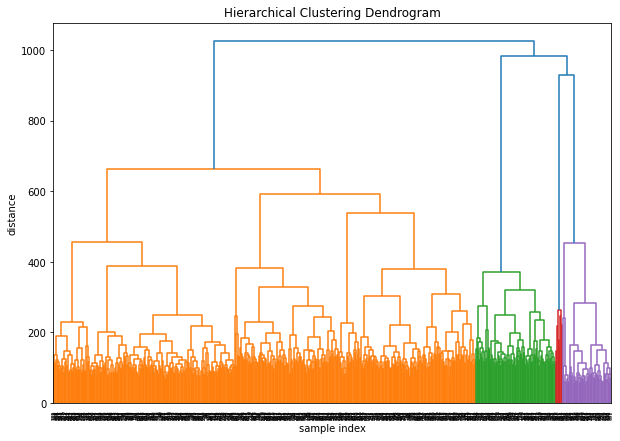

In [61]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
pred_lab = hierarchical_cluster.fit_predict(X_train)
# visualize the clustering
plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel('sample index')
plt.ylabel('distance')
plt.xticks([])
dend = dendrogram(linkage(X_train, method='ward'))
plt.show()

<AxesSubplot:>

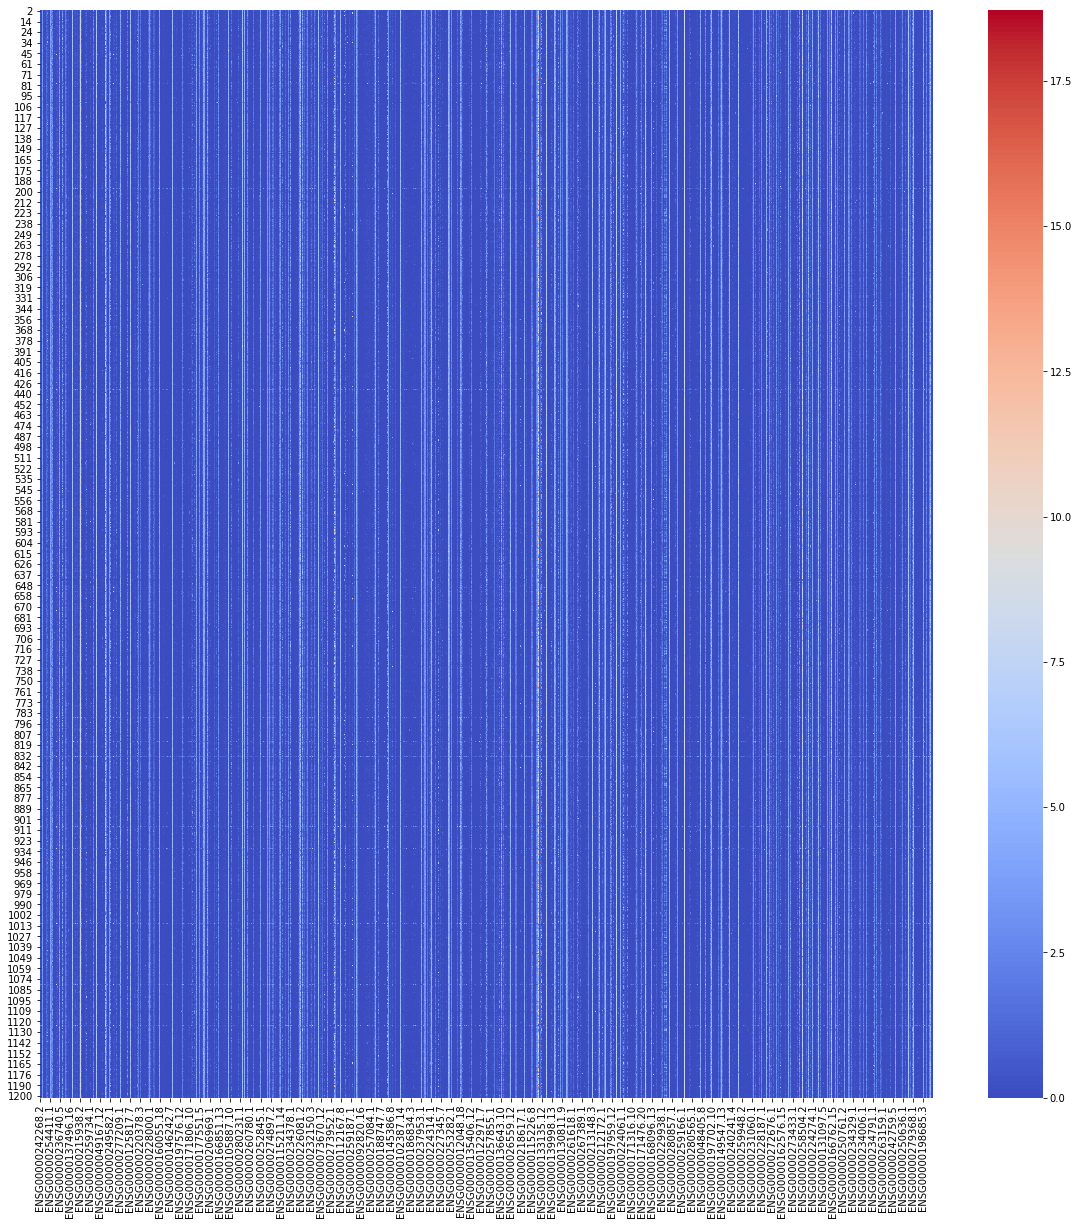

In [57]:
plt.figure(figsize=(20, 20))
sns.heatmap(X, fmt='.1g', cmap='coolwarm')